In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy.signal import welch
from detect_peaks import detect_peaks
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
#Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:

from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [4]:
def BearingInfomation(UserInput):
    n = UserInput['n']
    N = UserInput['N']
    Bd = UserInput['Bd']
    Pd = UserInput['Pd']
    phi = UserInput['Phi']
    xx = Bd/Pd*np.cos(phi)
    BPFI = (N/2)*(1 + xx)*n
    BPFO = (N/2)*(1 - xx)*n
    BSF = (Pd/(2*Bd))*(1-(xx)**2)*n
    FTF= (1/2)*(1 - xx)*n
    x = {
        "BPFI": BPFI,
        "BPFO": BPFO,
        "BSF":  BSF,
        "FTF":  FTF
    }
    return x

In [5]:
def RemoveDCOffset(UserInput):
    UserInput["Signal Data of Interest"] = UserInput["Signal Data of Interest"] - np.mean(UserInput["Signal Data of Interest"])
    return UserInput

In [6]:
def FourierTransform(UserInput):
    #Fast Fourier Transform
    sig = UserInput['Signal Data of Interest']
    NumberOfSamples = UserInput['Number of Samples']
    Tmax = UserInput['Time of Sampling']
    frq = np.arange(NumberOfSamples)/(Tmax)# two sides frequency range
    frq = frq[range(int(NumberOfSamples/(2)))] # one side frequency range
    Y = abs(np.fft.fft(sig))/NumberOfSamples # fft computing and normalization
    Y = Y[range(int(NumberOfSamples/2))]
    #End fft
    x = {
        "Frequency":frq,
        "Freq. Amp.": Y
        }
    return x

In [7]:
def get_psd_values(UserInput):
    sig = UserInput['Signal Data of Interest']
    SamplingFrequency = UserInput['Sampling Frequency']
    frq, psd_values = welch(sig, fs=SamplingFrequency)
    x = {
        "Frequency":frq,
        "PSD": psd_values
        }
    return x

In [8]:
def autocorr(x):
    #Subfunction of get_autocorr_values
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(UserInput):
    sig = UserInput['Signal Data of Interest']
    Tmax = UserInput['Time of Sampling']
    N = UserInput['Number of Samples']
    autocorr_values = autocorr(sig)
    x_values = np.array([Tmax * jj for jj in range(0, N)])
    x = {
        "X Values":x_values,
        "Autocorr Values": autocorr_values
        }
    return x

In [9]:
def TimeDomainInformation(UserInput):
    sig = UserInput['Signal Data of Interest']
    x = {
        "RMS": np.mean(sig**2),
        "STD": np.std(sig),
        "Mean": np.mean(sig),
        "Max": np.max(sig),
        "Min": np.min(sig),
        "Peak-to-Peak": (np.max(sig) - np.min(sig)),
        "Max ABS": np.max(abs(sig)),
        "Kurtosis": kurtosis(sig),
        "Skew": skew(sig),
    }

    return x

In [10]:
def GetSortedPeak(X,Y):
    #SubFunction for FrequencyDomainInformation
    max_peak_height = 0.1 * np.nanmax(Y)
    threshold = 0.05 * np.nanmax(Y)
    #Get indices of peak
    peak = detect_peaks(Y,edge = 'rising',mph = max_peak_height, mpd = 2, threshold = threshold )
    
    m = []
    mm = []
    for i in peak:
        m.append(Y[i]) 
        mm.append(X[i])

    mmm = np.argsort(m)
    n = []
    nn = []
    for i in mmm:
        n.append(m[i])
        nn.append(mm[i])

    n  = n[::-1]
    nn = nn[::-1]

    return n, nn

def FrequencyDomainInformation(UserInput):
    x1 = FourierTransform(UserInput)
    x2 = get_psd_values(UserInput)
    x3 = get_autocorr_values(UserInput)
    FTamp,FTfreq = GetSortedPeak(x1['Frequency'],x1['Freq. Amp.'])
    PSDamp,PSDfreq = GetSortedPeak(x2['Frequency'],x2['PSD'])
    Cor,CorTime = GetSortedPeak(x3['X Values'],x3['Autocorr Values'])

    while len(FTamp) <= 5:
        FTamp.append(['-999'])
    while len(FTfreq) <= 5:
        FTfreq.append(['-999'])
    while len(PSDamp) <= 5:
        PSDamp.append(['-999'])
    while len(PSDfreq) <= 5:
        PSDfreq.append(['-999'])
    while len(Cor) <= 5:
        Cor.append(['-999'])
    while len(CorTime) <= 5:
        CorTime.append(['-999'])
    
    x = {
        "FFT Frq @ Peak 1": FTfreq[0],
        "FFT Frq @ Peak 2": FTfreq[1],
        "FFT Frq @ Peak 3": FTfreq[2],
        "FFT Frq @ Peak 4": FTfreq[3],
        "FFT Frq @ Peak 5": FTfreq[4],
        "FFT Amp @ Peak 1": FTamp[0],
        "FFT Amp @ Peak 2": FTamp[1],
        "FFT Amp @ Peak 3": FTamp[2],
        "FFT Amp @ Peak 4": FTamp[3],
        "FFT Amp @ Peak 5": FTamp[4],
        "PSD Frq @ Peak 1": PSDfreq[0],
        "PSD Frq @ Peak 2": PSDfreq[1],
        "PSD Frq @ Peak 3": PSDfreq[2],
        "PSD Frq @ Peak 4": PSDfreq[3],
        "PSD Frq @ Peak 5": PSDfreq[4],
        "PSD Amp @ Peak 1": PSDamp[0],
        "PSD Amp @ Peak 2": PSDamp[1],
        "PSD Amp @ Peak 3": PSDamp[2],
        "PSD Amp @ Peak 4": PSDamp[3],
        "PSD Amp @ Peak 5": PSDamp[4],
        "Autocorrelate Time @ Peak 1": CorTime[0],
        "Autocorrelate Time @ Peak 2": CorTime[1],
        "Autocorrelate Time @ Peak 3": CorTime[2],
        "Autocorrelate Time @ Peak 4": CorTime[3],
        "Autocorrelate Time @ Peak 5": CorTime[4],
        "Autocorrelate @ Peak 1": Cor[0],
        "Autocorrelate @ Peak 2": Cor[1],
        "Autocorrelate @ Peak 3": Cor[2],
        "Autocorrelate @ Peak 4": Cor[3],
        "Autocorrelate @ Peak 5": Cor[4]
    }
    return x

In [11]:
"""
http://mkalikatzarakis.eu/wp-content/uploads/2018/12/IMS_dset.html
Previous work done on this dataset states that seven different states of health were observed:

Early (initial run-in of the bearings)
Normal
Suspect (the health seems to be deteriorating)
Imminent failure (for bearings 1 and 2, which didn’t actually fail, but were severely worn out)
Inner race failure (bearing 3)
Rolling element failure (bearing 4)
Stage 2 failure (bearing 4)
For the first test (the one we are working on), the following labels have been proposed per file:

Bearing 1
early: 2003.10.22.12.06.24 - 2013.10.23.09.14.13
suspect: 2013.10.23.09.24.13 - 2003.11.08.12.11.44 (bearing 1 was in suspicious health from the beginning, but showed some self-healing effects)
normal: 2003.11.08.12.21.44 - 2003.11.19.21.06.07
suspect: 2003.11.19.21.16.07 - 2003.11.24.20.47.32
imminent failure: 2003.11.24.20.57.32 - 2003.11.25.23.39.56

Bearing 2
early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
normal: 2003.11.01.21.51.44 - 2003.11.24.01.01.24
suspect: 2003.11.24.01.11.24 - 2003.11.25.10.47.32
imminent failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

Bearing 3
early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
normal: 2003.11.01.21.51.44 - 2003.11.22.09.16.56
suspect: 2003.11.22.09.26.56 - 2003.11.25.10.47.32
Inner race failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

Bearing 4
early: 2003.10.22.12.06.24 - 2003.10.29.21.39.46
normal: 2003.10.29.21.49.46 - 2003.11.15.05.08.46
suspect: 2003.11.15.05.18.46 - 2003.11.18.19.12.30
Rolling element failure: 2003.11.19.09.06.09 - 2003.11.22.17.36.56
Stage 2 failure: 2003.11.22.17.46.56 - 2003.11.25.23.39.56
"""

def getAbsoluteTime(file):
    #Subfunction for StateInformation
    year   = int(file[0:4])
    month  = int(file[5:7])
    day    = int(file[8:10])
    hour   = int(file[11:13])
    minute = int(file[14:16])
    second = int(file[17:19])
    x = second + 60*minute + 60*60*hour + 24*60*60*day + 31*24*60*60*(month - 10)
    return x

def StateInformation(UserInput,BearingNum):
    file = UserInput['File of Interest']
    absolutetime = getAbsoluteTime(file)
    #in seconds don't include years taking 10 as the start month
    
    #Bearing 1 transitions
    b1e2s  = getAbsoluteTime("2013.10.23.09.14.13")
    b1s2n  = getAbsoluteTime("2003.11.08.12.11.44")
    b1n2s  = getAbsoluteTime("2003.11.19.21.06.07")
    b1s2i  = getAbsoluteTime("2003.11.24.20.47.32")
    
    #Bearing 2 transitions
    b2e2n  = getAbsoluteTime("2003.11.01.21.41.44")
    b2n2s  = getAbsoluteTime("2003.11.24.01.01.24")
    b2s2i  = getAbsoluteTime("2003.11.25.10.47.32")
    
    #Bearing 3 transitions
    b3e2n  = getAbsoluteTime("2003.11.01.21.41.44")
    b3n2s  = getAbsoluteTime("2003.11.22.09.16.56")
    b3s2irf  = getAbsoluteTime("2003.11.25.10.47.32")
    
    #Bearing 4 transitions
    b4e2n  = getAbsoluteTime("2003.10.29.21.39.46")
    b4n2s  = getAbsoluteTime("2003.11.15.05.08.46")
    b4s2r  = getAbsoluteTime("2003.11.18.19.12.30")
    b4r2f  = getAbsoluteTime("2003.11.22.17.36.56")
    
    m = "ERROR"
    if BearingNum == 1:
        if absolutetime   <= b1e2s:
            m = "Early"
        elif absolutetime <= b1s2n:
            m = "Suspect"
        elif absolutetime <= b1n2s:
            m = "Normal"
        elif absolutetime <= b1s2i:
            m = "Suspect"
        elif absolutetime > b1s2i:
            m = "Imminent Failure"
    elif BearingNum == 2:
        if absolutetime   <= b2e2n:
            m = "Early"
        elif absolutetime <= b2n2s:
            m = "Normal"
        elif absolutetime <= b2s2i:
            m = "Suspect"
        elif absolutetime > b2s2i:
            m = "Imminent Failure" 
    elif BearingNum == 3:
        if absolutetime   <= b3e2n:
            m = "Early"
        elif absolutetime <= b3n2s:
            m = "Normal"
        elif absolutetime <= b3s2irf:
            m = "Suspect"
        elif absolutetime >= b3s2irf:
            m = "Inner Race Failure"   
    elif BearingNum == 4:
        if absolutetime   <= b4e2n:
            m = "Early"
        elif absolutetime <= b4n2s:
            m = "Normal"
        elif absolutetime <= b4s2r:
            m = "Suspect"
        elif absolutetime <= b4r2f:
            m = "Rolling Element Failure"
        elif absolutetime > b4r2f:
            m = "Stage 2 Failure"
    else:
        m = "ERROR"
        
    x = {
        "State": m
    }
    return x

In [12]:
def MotorInformation(UserInput):
    x = {
        "Motor Type AC(1)-DC(0)": 1,
        "Shaft Speed [Hz]": 2000/60
    }
    return x

In [13]:
def getCompleteDataFrame(UserInput,BearingNum):
    UserInput1 = UserInput
    UserInput1 = RemoveDCOffset(UserInput1)
    BearingInfo = BearingInfomation(UserInput1)
    TimeDomainInfo = TimeDomainInformation(UserInput1)
    FrequecyDomainInfo = FrequencyDomainInformation(UserInput1)
    StateInfo = StateInformation(UserInput1,BearingNum)
    MotorInfo = MotorInformation(UserInput1)
    Features = {**StateInfo,**MotorInfo,**BearingInfo,**TimeDomainInfo,**FrequecyDomainInfo}
    Features = pd.DataFrame(Features, index=[0])
    return Features 

In [14]:
def getTESTDataFrame(UserInput):
    UserInput1 = UserInput
    UserInput1 = RemoveDCOffset(UserInput1)
    BearingInfo = BearingInfomation(UserInput1)
    TimeDomainInfo = TimeDomainInformation(UserInput1)
    FrequecyDomainInfo = FrequencyDomainInformation(UserInput1)
    MotorInfo = MotorInformation(UserInput1)
    Features = {**MotorInfo,**BearingInfo,**TimeDomainInfo,**FrequecyDomainInfo}
    Features = pd.DataFrame(Features, index=[0])
    return Features 

In [15]:
def getPlot(X,Y,xlabel,ylabel,Title):
    #Subfunction of getGraphs
    fig = plt.figure()
    plt.plot(X,Y,c = np.random.rand(3,))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(Title)
    plt.grid(True)
    return fig

def getGraphs(UserInput):
    t = np.arange(0,UserInput['Time of Sampling'],1/UserInput['Sampling Frequency'])
    figs = []
    x1 = FourierTransform(UserInput)
    x2 = get_psd_values(UserInput)
    x3 = get_autocorr_values(UserInput)
    UserInput1 = RemoveDCOffset(UserInput)
    figs.append(getPlot(t,UserInput['Signal Data of Interest'],"time (s)","Amplitude","Raw Data"))
    figs.append(getPlot(t,UserInput1['Signal Data of Interest'],"time (s)","Amplitude","Raw Data w/ Removed DC Offset"))
    figs.append(getPlot(x1['Frequency'],x1['Freq. Amp.'],'Frequency [Hz]',"time (s)","FFT"))
    figs.append(getPlot(x2['Frequency'],x2['PSD'],'Frequency [Hz]','PSD [V**2 / Hz]',"PSD"))
    figs.append(getPlot(x3['X Values'],x3['Autocorr Values'],'time delay [s]',"Autocorrelation amplitude","Autocorrelation"))

    return figs

In [16]:
def getBarPlot(X,Y,xlabel,Title):
    #Subfunction of getGraphs
    fig = plt.figure()
    y_pos = np.arange(len(Y))
    plt.barh(y_pos, X, align='center')
    plt.xlabel(xlabel, fontsize=12)
    plt.yticks(y_pos, Y)
    plt.title(Title)
    plt.grid(True)
    return fig

In [17]:
def GetData(FileOfInterest):
    #Subfunction for UserInputs2WorkingForm
    data = pd.read_table(FileOfInterest,header = None)
    data.columns = ['b1x','b1y','b2x','b2y','b3x','b3y','b4x','b4y']
    return np.transpose(data.values[:,0])

def UserInputs2WorkingForm(n,N,Bd,Pd,phi,SampleFrequency,FileOfInterest,\
                           HomeDirectory,directory,TrainingDataFile):
    sig = GetData(FileOfInterest)
    NumberOfSamples = len(sig)
    dt = 1/SampleFrequency
    Tmax = dt*NumberOfSamples
    x = {
        'n': n, #Shaft rotational speed [Hz], n
        'N': N, #No. of rolling elements [-], N
        'Bd': Bd, #Diameter of a rolling element [mm], Bd
        'Pd': Pd, #Pitch diameter [mm], Pd
        'Phi': phi, #Contact angle [rad], Phi
        'Sampling Frequency': SampleFrequency,
        'Time of Sampling': Tmax,
        'Number of Samples': NumberOfSamples,
        'File of Interest': FileOfInterest,
        'HomeDirectory': HomeDirectory,
        'Working Directory': directory,
        'TrainingFileName': TrainingDataFile,
        'Signal Data of Interest': sig    
    }
    return x

In [18]:
def truncate(f, n):
    '''https://stackoverflow.com/questions/783897/truncating-floats-in-python/51172324#51172324'''
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [19]:
def GetTrainingData(UserInput):
    for file in UserInput['Working Directory']:
        if file == UserInput['TrainingFileName']:
            dataset = pd.read_csv(file,header = 0,index_col = 0)

    X = dataset.values[:,1:(dataset.shape[1]-1)]
    Y = dataset.values[:,0]
    validation_size = 0.20
    seed = 6
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed) 
    
    return X_train, X_test, Y_train, Y_test

In [20]:
def GetTESTDataFrameNames(UserInput):
    for file in UserInput['Working Directory']:
        if file == UserInput['TrainingFileName']:
            dataset = pd.read_csv(file,header = 0,index_col = 0)
    names = []
    for x in dataset.columns:
        names.append(x)
    return names

In [21]:
def TrainModel(X_train,Y_train):
    classifier = RandomForestClassifier(n_estimators=1000)
    classifier = classifier.fit(X_train, Y_train)
    return classifier

In [22]:
def PredictModel(classifier,X_test):
    Y_test_pred = classifier.predict(X_test)
    return Y_test_pred

In [23]:
def GetAllModelsForComparison(X_train,Y_train):
    models = {
        'LR': LogisticRegression(solver='liblinear', multi_class='ovr'),
        'LDA': LinearDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(),
        'CART': DecisionTreeClassifier(),
        'NB': GaussianNB(),
        'RFC': RandomForestClassifier(n_estimators=1000),
        'SVM': SVC(gamma='auto'),
        }
    return models

In [24]:
def GetUserInputNames(UserInput):
    names = []
    for x in UserInput:
        names.append(x)
    return names

In [25]:
#BEGIN HARDCODING OF GUI INFO
n = 2000 / 60
N = 16
Bd = 0.331*254
Pd = 2.815*254
phi = 15.17 * np.pi / 180
SampleFrequency = 20000
FileOfInterest = '2003.10.22.12.06.24'
HomeDirectory = os.getcwd()
os.chdir(HomeDirectory)
directory = os.listdir(HomeDirectory)
TrainingDataFile = "DELETE.csv"
#END OF HARDCODING OF GUI INFO

In [26]:
UserInput = UserInputs2WorkingForm(n,N,Bd,Pd,phi,SampleFrequency,FileOfInterest,HomeDirectory,directory,TrainingDataFile)
X_train, X_test, Y_train, Y_test = GetTrainingData(UserInput)
classifier = TrainModel(X_train, Y_train)
Y_test_pred = PredictModel(classifier,X_test)

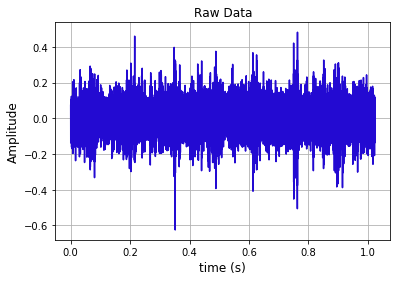

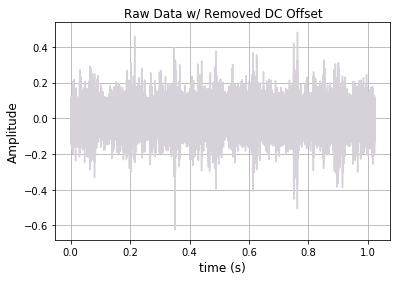

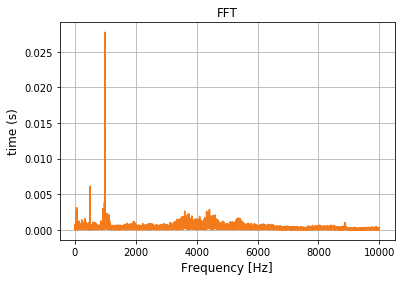

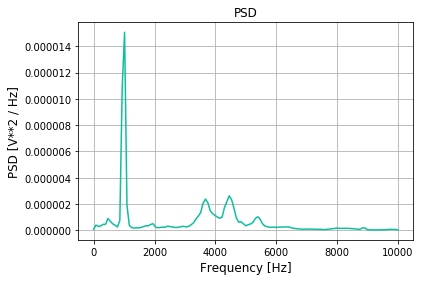

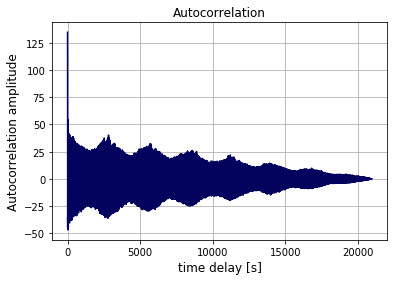

In [27]:
TEST = getTESTDataFrame(UserInput)
TEST1 = TEST.values[:,0:(TEST.shape[1]-1)]
OUTCOME = PredictModel(classifier,TEST1)
figs = getGraphs(UserInput)

In [28]:
print(OUTCOME)
print("Accuracy on training set is : {}".format(classifier.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(classifier.score(X_test, Y_test)))
print(classification_report(Y_test, Y_test_pred))

['Early']
Accuracy on training set is : 1.0
Accuracy on test set is : 0.9257971014492754
                         precision    recall  f1-score   support

                  Early       0.98      0.92      0.95       276
       Imminent Failure       1.00      0.75      0.86        20
     Inner Race Failure       0.90      1.00      0.95         9
                 Normal       0.91      0.97      0.94       879
Rolling Element Failure       0.98      0.94      0.96        63
        Stage 2 Failure       0.94      0.98      0.96        64
                Suspect       0.92      0.84      0.88       414

            avg / total       0.93      0.93      0.93      1725



In [31]:
models = GetAllModelsForComparison(X_train,Y_train)
# evaluate each model in turn

results = []
names = []
for ModelName in models:
    
    CTest = models[ModelName].fit(X_train, Y_train)
    print ("The accuracy of {} is: {}".format(ModelName,CTest.score(X_test, Y_test))) 


The accuracy of LR is: 0.6
The accuracy of LDA is: 0.5333333333333333
The accuracy of KNN is: 0.6707246376811594


/Users/tbryan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/tbryan/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The accuracy of CART is: 0.8597101449275363
The accuracy of NB is: 0.25043478260869567
The accuracy of RFC is: 0.927536231884058
The accuracy of SVM is: 0.5252173913043479


In [ ]:
fig2 = getBarPlot(CTest.feature_importances_[1:20],GetTESTDataFrameNames(UserInput)[1:20],"Relative Importance","Feature Importance")